# Interconnect Churn Prediction PipeLine

This project will provide insights into the causes and the rate at which customers are leaving the company. This is often referred to as churn analysis. By studying these effects using exploratory data analysis and machine learning techniques, I will analyze different factors and attributes of customers who churned and those who did not churn.

The goal of this project is to create a machine learning pipeline that will yield valuable insights and a machine learning model capable of predicting the probability of a customer churning within a four-month period. I will conduct data analysis using historical data from a four-month period for modeling and analysis.

## Libraries

In [142]:
import os
from datetime import datetime as dt

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.feature_selection import RFE
from sklearn.metrics import (accuracy_score, auc, average_precision_score,
                             confusion_matrix, f1_score, precision_recall_curve,
                             precision_score, recall_score, roc_auc_score,
                             roc_curve, classification_report)

from sklearn.model_selection import (GridSearchCV, RandomizedSearchCV,
                                     cross_val_score, train_test_split)

from sklearn.preprocessing import LabelEncoder, MinMaxScaler, OneHotEncoder, StandardScaler
from sklearn.utils import resample
from sklearn.model_selection import StratifiedKFold

import random
import warnings

# Set a random seed for reproducibility
random.seed(369)
# Filter out specific warnings
warnings.filterwarnings("ignore")


## Variables 

###### Paths for loading data and saving graphs. 

In [158]:
data_path = '/Users/ericross/Desktop/Interconnect_churn_prediction/Data/origin_datasets/'

graph_path = '/Users/ericross/Desktop/Interconnect_churn_prediction/Charts/'

save_chart_path = graph_path

###### Colors For EDA

In [67]:
my_red= '#b72424'
my_green= '#53802d'

light_background= '#b3b3b3'
dark_background= '#4f4f4f'

## FUNCTIONS

### Preprocessing -Func.

##### `get_col_percent_share()`

In [68]:

def get_col_percent_share(data):
    """
    Calculate the count and percentage share of each unique value in columns with string or object values,
    ignoring columns with more than 100 unique values.

    Parameters:
        data (DataFrame): The input DataFrame.

    Returns:
        DataFrame: A DataFrame where each row represents a unique value in a column,
                   along with its count and percentage share.

    """
    string_columns = data.select_dtypes(include=['object']).columns
    result = pd.DataFrame()

    for column in string_columns:
        unique_values = data[column].nunique()
        if unique_values > 100:
            continue

        value_counts = data[column].value_counts()
        total_count = len(data[column])
        percentages = (value_counts / total_count) * 100
        column_result = pd.DataFrame({'Count': value_counts, '%-Share': percentages})
        
        print("------",column,"--------------------")
        print(column_result)
          # Print the name of the column
        print()


### Exploratory Data Analysis -Func.

##### `churn_pie_whole`

In [69]:
def churn_pie_whole(data, values, title, file_name):
    """
    Plot a pie chart for the specified column values and 'is_churned' column.

    Parameters:
        data (DataFrame): The input DataFrame.
        values (str): The name of the column containing the values to plot.
        title (str): The title of the pie chart.
        file_name (str): the name of file for piec chart. 
    Returns:
        DataFrame: The pivot table used for the pie chart.
    """
    table = data.pivot_table(values=values, index='churn', aggfunc='count')

    colors = {'Yes': my_red, 'No': my_green}

    explode = [0.1 if c == 'Yes' else 0 for c in table.index]
    legend_labels = ['Churn', 'Non-Churn']

    fig, ax = plt.subplots(figsize=(5,5))
    ax.pie(table[values], labels=None, colors=[colors.get(c, 'gray') for c in table.index], autopct='%1.1f%%', explode=explode, shadow=True)
    ax.legend(legend_labels, loc='center', bbox_to_anchor=(0.5, -0.1))
    ax.set_title(title)
    fig.set_facecolor(dark_background)

   
    graph_path = save_chart_path + file_name

    # Check if the file already exists
    if os.path.isfile(graph_path):
        print("The file already exists.")
    else:
        # Save the chart to the specified file path
        plt.savefig(graph_path)
        print(f"The chart saved to {graph_path}")
    
    plt.show()
   
    return table

##### `churn_pie_multiple_groups`

In [70]:
def churn_pie_multiple_groups(data, column, file_name):
    """
    Plot pie charts based on the specified column and 'is_churned' column.
    The pie charts are ordered based on the highest to lowest 'is_churned' imbalance.

    Parameters:
        data (DataFrame): The input DataFrame.
        column (str): The name of the column containing multiple classes.
        file_name (str): the name to save chart, chart_path, will be the directory for project. 
    Returns:
        None
    """
    # Create a pivot table based on 'is_churned' and the specified column
    table = data.pivot_table(values='customerID', index=column, columns='churn', aggfunc='count')

    # Calculate the 'is_churned' imbalance for each class
    imbalance = table['Yes'] / table.sum(axis=1)

    # Sort the classes based on the imbalance in descending order
    sorted_classes = imbalance.sort_values(ascending=False).index

    # Define the colors for the pie chart slices
    colors = {'Yes': my_red, 'No': my_green}

    # Calculate the number of rows and columns for the grid
    num_classes = len(table.index)
    num_columns = min(4, num_classes)
    num_rows = int(np.ceil(num_classes / num_columns))

    # Create the grid of subplots
    fig, axes = plt.subplots(num_rows, num_columns, figsize=(15, 5.5*num_rows))

    # Flatten the axes array to iterate over it
    axes = axes.flatten()

    for i, class_value in enumerate(sorted_classes):
        # Plot the pie chart for each class value
        explode = [0.1 if c == 'Yes' else 0 for c in table.columns]
        legend_labels = ['Current', 'Churn']
        axes[i].pie(table.loc[class_value],
                    colors=[colors.get(c, 'gray') for c in table.columns],
                    autopct='%1.1f%%',
                    shadow=True,
                    explode=explode,
                    )
        
        count = table.loc[class_value].sum()
        percent_share = (count / table.values.sum()) * 100
        axes[i].text(0.5, 0, f"Count: {count} ({percent_share:.1f}%)", transform=axes[i].transAxes, ha='center')
        
        if class_value in [0, 1]:
            # Change class_value to 'Yes' if it is 1, or 'No' if it is 0
            class_label = 'Yes' if class_value == 1 else 'No'
            axes[i].set_title(f"{class_label}", fontsize=14, y=0.925)
        else:
            axes[i].set_title(f"{class_value}", fontsize=14, y=0.925)
        
        
# percentage text objects in pie chart
        percent_texts = [t for t in axes[i].texts if '%' in t.get_text()]
    
        for text in percent_texts:
            text.set_fontsize(12)
        
        
        # Set the aspect ratio to be equal to ensure circular pie charts
        axes[i].set_aspect('equal')

    # Remove any empty subplots
    if num_classes < num_rows * num_columns:
        for j in range(num_classes, num_rows * num_columns):
            fig.delaxes(axes[j])

    # Set the title of the figure
    fig.suptitle(f"Pie Charts: churn by classes in {column}", fontsize=16)

    # Adjust spacing between subplots
    fig.tight_layout()
    fig.set_facecolor(dark_background)
    
        # Set legend color and text color
    legend = fig.legend(legend_labels, title='Legend', loc='upper right')
    legend.get_frame().set_facecolor('white')
    legend.get_texts()[0].set_color('black')
    legend.get_texts()[1].set_color('black')

    # Combine the directory path and file name to create the complete file path
    chart_save = save_chart_path + file_name

    # Check if the file already exists
    if os.path.isfile(chart_save):
        print("The file already exists.")
    else:
        # Save the chart to the specified file path
        plt.savefig(chart_save)
        print(f"The chart saved to {chart_save}")
   
   
    # Show the plot
    plt.show()
    
    return table

##### `hist_plot'

In [71]:
def hist_plot(data, column, file_name):

    pivot_table = pd.pivot_table(data=data,
                                 values=[column],
                                 index=['customerID'],
                                 columns=['churn'],
                                 aggfunc='mean')

    churned_data = pivot_table[column]['Yes'].dropna()
    current_data = pivot_table[column]['No'].dropna()

    
    fig, axes = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(12, 5))

    axes[0].hist(churned_data, bins=20, alpha=0.80, label='Churned Customers (Yes)', color=my_red, edgecolor=my_red)
    axes[0].set_title('Churned Customers (Yes)')
    axes[0].set_xlabel(column)
    axes[0].set_ylabel('Count')
    axes[0].set_facecolor(light_background)
    
    axes[1].hist(current_data, bins=20, alpha=0.80, label='Current Customers (No)', color=my_green, edgecolor=my_green)
    axes[1].set_title('Current Customers (No)', fontsize=16)
    axes[1].set_xlabel(column, fontsize=14)
    axes[1].set_ylabel('Count', fontsize=14)
    axes[1].set_facecolor(light_background)


    fig.set_facecolor(dark_background)
    fig.tight_layout()
    
        # Combine the directory path and file name to create the complete file path
    graph_path = save_chart_path + file_name

    # Check if the file already exists
    if os.path.isfile(graph_path):
        print("The file already exists.")
    else:
        # Save the chart to the specified file path
        plt.savefig(graph_path)
        print(f"The chart saved to {graph_path}")
   
   
    # Show the plot
    plt.show()

# Preprocessing

## Load Data

`customer_ID` - unique Keys across data, 

`EndDate` - target values for Churn over four months. 

**Data Sets.**

- `contract.csv`- Financial, Dates, Payment Method Information, includes target column for Churn.
- `personal.csv`- Basic Personal Information like Gender, Senior Citizen, Couple, Dependant. 
- `internet.csv`- Internet Service type and some addition services. 
- `phone.csv`- 'MultipleLines', is the only informational column.

In [72]:
contract_raw = pd.read_csv(
    '/Users/ericross/Desktop/Interconnect_churn_prediction/Data/origin_datasets/contract.csv',
    parse_dates=[1])

In [73]:
#Client information.
personal_raw = pd.read_csv(
    '/Users/ericross/Desktop/Interconnect_churn_prediction/Data/origin_datasets/personal.csv')

In [74]:
#internet packages.
internet_raw = pd.read_csv(
   '/Users/ericross/Desktop/Interconnect_churn_prediction/Data/origin_datasets/internet.csv')

In [75]:
# landline plan: multiple lines/ 'yes or no'
phone_raw = pd.read_csv(
    '/Users/ericross/Desktop/Interconnect_churn_prediction/Data/origin_datasets/phone.csv')

## Cleaning By DataFrame

### Contract_Clean:

##### Contract Summary

`TotalCharge` Contains 11 or ~0.15% empty values.
1. understand the issue.
    - get "customer_ID" for all missing values.
    - fill with correct values, if possible, using the 'customer_ID' 


2. `EndDate` Contains "No" and Date values.
    - `churn` - a column for the "No" values, filling the date values with "Yes"
    - `EndDate` - fill "No" with the current date of date the data was validated. 
    


3. `tenure` - new column 
    - number of months between start and end of service. 

##### Data Overveiw. 

In [76]:
contract_raw.sample(5)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
501,4513-CXYIX,2014-03-01,No,Two year,Yes,Credit card (automatic),80.70,5676
6503,7781-EWARA,2014-04-01,No,One year,No,Electronic check,60.35,4138.7
4967,4398-HSCJH,2019-10-01,2020-01-01 00:00:00,Month-to-month,Yes,Electronic check,63.60,155.65
6087,8319-QBEHW,2017-12-01,No,One year,Yes,Bank transfer (automatic),39.95,1023.75
4195,1768-HNVGJ,2016-05-01,No,Month-to-month,Yes,Electronic check,70.05,3062.45


In [77]:
contract_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   object        
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   object        
dtypes: datetime64[ns](1), float64(1), object(6)
memory usage: 440.3+ KB


In [78]:
get_col_percent_share(contract_raw)

------ EndDate --------------------
                     Count    %-Share
EndDate                              
No                    5174  73.463013
2019-11-01 00:00:00    485   6.886270
2019-12-01 00:00:00    466   6.616499
2020-01-01 00:00:00    460   6.531308
2019-10-01 00:00:00    458   6.502911

------ Type --------------------
                Count    %-Share
Type                            
Month-to-month   3875  55.019168
Two year         1695  24.066449
One year         1473  20.914383

------ PaperlessBilling --------------------
                  Count    %-Share
PaperlessBilling                  
Yes                4171  59.221922
No                 2872  40.778078

------ PaymentMethod --------------------
                           Count    %-Share
PaymentMethod                              
Electronic check            2365  33.579441
Mailed check                1612  22.887974
Bank transfer (automatic)   1544  21.922476
Credit card (automatic)     1522  21.610109



##### `contract_cleaned` - DataFrame where cleaning is preformed. 

In [79]:
contract_cleaned = contract_raw.copy()

##### `EndDate` & `churn` - Target Columns 

In [80]:
## 'is_churned' is "No" and "Yes" 
contract_cleaned['churn'] = contract_cleaned['EndDate']

contract_cleaned.loc[contract_cleaned['churn'] != 'No', 'churn'] = "Yes"


In [81]:
contract_cleaned.churn.value_counts()

churn
No     5174
Yes    1869
Name: count, dtype: int64

In [82]:
contract_cleaned.BeginDate.max()

Timestamp('2020-02-01 00:00:00')

In [83]:
from datetime import datetime

# define 'fill_date' 
## fill "No" with "current or validation date".

fill_date = "February 1, 2020"



date_object = datetime.strptime(fill_date, "%B %d, %Y")
fill_date = date_object.strftime("%Y-%m-%d")

print('Fill date,', fill_date)

# filled with current date. 
contract_cleaned.loc[contract_cleaned['EndDate'] == "No", 'EndDate'] = fill_date

Fill date, 2020-02-01


In [84]:
contract_cleaned[['EndDate','churn']].sample(5)

,EndDate,churn
5163,2020-02-01,No
6919,2020-02-01,No
5037,2019-11-01 00:00:00,Yes
5521,2020-02-01,No
4144,2020-02-01,No


#####  `tenure`

In [85]:
contract_cleaned['EndDate']

0                2020-02-01
1                2020-02-01
2       2019-12-01 00:00:00
3                2020-02-01
4       2019-11-01 00:00:00
               ...         
7038             2020-02-01
7039             2020-02-01
7040             2020-02-01
7041    2019-11-01 00:00:00
7042             2020-02-01
Name: EndDate, Length: 7043, dtype: object

In [86]:
contract_cleaned['EndDate'] = pd.to_datetime(contract_cleaned['EndDate'], format='mixed')
contract_cleaned['BeginDate'] = pd.to_datetime(contract_cleaned['BeginDate'])

contract_cleaned['tenure'] = ((contract_cleaned.EndDate - contract_cleaned.BeginDate) / np.timedelta64(1, 'M')).astype(int)                         
contract_cleaned['tenure'].sample(5)

6858    24
1981    56
5996    60
2040    69
3307    47
Name: tenure, dtype: int64

In [87]:
contract_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   object        
 8   churn             7043 non-null   object        
 9   tenure            7043 non-null   int64         
dtypes: datetime64[ns](2), float64(1), int64(1), object(6)
memory usage: 550.4+ KB


##### `TotalCharges` - some values are empty causing issues 

In [88]:
contract_cleaned['TotalCharges'] = contract_cleaned["TotalCharges"].replace(" ",np.nan)

In [89]:
contract_cleaned.isna().sum()

customerID           0
BeginDate            0
EndDate              0
Type                 0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
churn                0
tenure               0
dtype: int64

In [90]:
per_share = (11/7043)*100

print(f'Share of Customers w/ missing info: ~{per_share:.2f}%')

Share of Customers w/ missing info: ~0.16%


In [91]:
missing_list = contract_cleaned.loc[contract_cleaned['TotalCharges'].isna(),"customerID"]
contract_cleaned.loc[contract_cleaned['customerID'].isin(missing_list)]

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,churn,tenure
488,4472-LVYGI,2020-02-01,2020-02-01,Two year,Yes,Bank transfer (automatic),52.55,NaN,No,0
753,3115-CZMZD,2020-02-01,2020-02-01,Two year,No,Mailed check,20.25,NaN,No,0
936,5709-LVOEQ,2020-02-01,2020-02-01,Two year,No,Mailed check,80.85,NaN,No,0
1082,4367-NUYAO,2020-02-01,2020-02-01,Two year,No,Mailed check,25.75,NaN,No,0
1340,1371-DWPAZ,2020-02-01,2020-02-01,Two year,No,Credit card (automatic),56.05,NaN,No,0
3331,7644-OMVMY,2020-02-01,2020-02-01,Two year,No,Mailed check,19.85,NaN,No,0
3826,3213-VVOLG,2020-02-01,2020-02-01,Two year,No,Mailed check,25.35,NaN,No,0
4380,2520-SGTTA,2020-02-01,2020-02-01,Two year,No,Mailed check,20.00,NaN,No,0
5218,2923-ARZLG,2020-02-01,2020-02-01,One year,Yes,Mailed check,19.70,NaN,No,0
6670,4075-WKNIU,2020-02-01,2020-02-01,Two year,No,Mailed check,73.35,NaN,No,0


In [92]:
charges_missing = contract_cleaned.loc[contract_cleaned['TotalCharges'].isna(), 'MonthlyCharges']
contract_cleaned.loc[contract_cleaned['TotalCharges'].isna(), 'TotalCharges'] = charges_missing.fillna(0)

In [93]:
contract_cleaned['TotalCharges'] = pd.to_numeric(contract_cleaned['TotalCharges'], errors='coerce',downcast='float')

In [94]:
contract_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   float32       
 8   churn             7043 non-null   object        
 9   tenure            7043 non-null   int64         
dtypes: datetime64[ns](2), float32(1), float64(1), int64(1), object(5)
memory usage: 522.8+ KB


In [95]:
contract_raw.shape, contract_cleaned.shape

((7043, 8), (7043, 10))

### Contract Conclusion

Data overview:

- Major class imbalance in target column 73.463013% are not Churned.
    - Stratify= 'y' -(*target values*) 
    - Sampling methods.

- (55.019168%) of  "Type" are month to month. 

- (automatic) payment options are less popular, with Churn for subscription, it is understood that type of payments are highly determinant of churn risk. 
    - a possible strategy could be to suggest insentives for automatic payments for customers with higher churn risks.  
    
Corrections and Changes:

- `contract_cleaned`-features resulting from the operations
    - 2 columns added  

Columns added:

- 'churned' == new target  
- 'tenure' ==  months between 'BeginDate' and 'EndDate'

## Personal_Clean:

##### Data Overview. 

In [96]:
personal_cleaned = personal_raw.copy()

In [97]:
personal_cleaned.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [98]:
personal_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [99]:
get_col_percent_share(personal_cleaned)

------ gender --------------------
        Count   %-Share
gender                 
Male     3555  50.47565
Female   3488  49.52435

------ Partner --------------------
         Count   %-Share
Partner                 
No        3641  51.69672
Yes       3402  48.30328

------ Dependents --------------------
            Count    %-Share
Dependents                  
No           4933  70.041176
Yes          2110  29.958824



##### Personal conclusion - "Dependent"- has a major imbalance. 

## Internet_Cleaned:

##### Data preview

In [100]:
internet_cleaned = internet_raw.copy()

In [101]:
internet_cleaned.sample(5)

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
4503,8679-LZBMD,Fiber optic,No,No,No,No,Yes,Yes
3144,2969-WGHQO,DSL,Yes,Yes,Yes,No,Yes,No
4555,4976-LNFVV,DSL,No,Yes,Yes,No,No,No
2910,8468-EHYJA,Fiber optic,Yes,No,No,No,Yes,Yes
3859,2626-URJFX,DSL,No,No,No,No,No,No


In [102]:
get_col_percent_share(internet_cleaned)

------ InternetService --------------------
                 Count    %-Share
InternetService                  
Fiber optic       3096  56.117455
DSL               2421  43.882545

------ OnlineSecurity --------------------
                Count    %-Share
OnlineSecurity                  
No               3498  63.404024
Yes              2019  36.595976

------ OnlineBackup --------------------
              Count    %-Share
OnlineBackup                  
No             3088  55.972449
Yes            2429  44.027551

------ DeviceProtection --------------------
                  Count    %-Share
DeviceProtection                  
No                 3095  56.099329
Yes                2422  43.900671

------ TechSupport --------------------
             Count    %-Share
TechSupport                  
No            3473  62.950879
Yes           2044  37.049121

------ StreamingTV --------------------
             Count    %-Share
StreamingTV                  
No            2810  50.933478


In [103]:
internet_cleaned.sample(5)

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
2512,6869-FGJJC,Fiber optic,No,Yes,Yes,No,No,No
2362,6214-EDAKZ,DSL,No,Yes,No,Yes,No,No
1531,0564-MUUQK,Fiber optic,No,No,Yes,Yes,No,Yes
3563,9415-TPKRV,DSL,No,Yes,No,No,No,No
1382,4137-JOPHL,Fiber optic,No,No,Yes,Yes,No,Yes


## Phone_Cleaned:        

##### Data Preview 

In [104]:
phone_cleaned = phone_raw.copy()

In [105]:
phone_cleaned.sample(5)

,customerID,MultipleLines
26,4929-XIHVW,No
2632,6652-YFFJO,No
4735,6854-EXGSF,Yes
3647,4006-HKYHO,No
4077,7853-WNZSY,No


In [106]:
get_col_percent_share(phone_cleaned)

------ MultipleLines --------------------
               Count    %-Share
MultipleLines                  
No              3390  53.293507
Yes             2971  46.706493



## Concatenating Data 

### `features_processed`

In [107]:
features_processed = pd.concat([contract_cleaned, personal_cleaned.drop(['customerID'],axis=1),
                         internet_cleaned.drop(['customerID'],axis=1), phone_cleaned.drop(['customerID'],axis=1)],
                        axis=1)

# checking to see the missing values from this concatination. 
print(features_processed.isna().sum())

customerID             0
BeginDate              0
EndDate                0
Type                   0
PaperlessBilling       0
PaymentMethod          0
MonthlyCharges         0
TotalCharges           0
churn                  0
tenure                 0
gender                 0
SeniorCitizen          0
Partner                0
Dependents             0
InternetService     1526
OnlineSecurity      1526
OnlineBackup        1526
DeviceProtection    1526
TechSupport         1526
StreamingTV         1526
StreamingMovies     1526
MultipleLines        682
dtype: int64


this shows that there are 1525 customers do not have internet services, and 682 do not have phone service services. <br>
<br>
`InternetService` - a 3rd value == 'none' will fill the values missing. 
- the other columns can be filled with "No" 

### observation after concat 


In [108]:
features_processed['MultipleLines'].fillna('No Service', inplace=True)
features_processed.fillna('No', inplace=True)

features_processed.isna().sum()

customerID          0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
churn               0
tenure              0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
MultipleLines       0
dtype: int64

## Preprocessing Conclusions. 

- **contract_clean**

    - 11 rows with missing == ~0.15%.
         - ll rows had empty values in the 'TotalCharges' column. 'tenure' == 0 fill with "MonthlyCharge"

    - 2 Columns added:

        - 'churn' == new target
        - 'tenure' == months between 'BeginDate' and 'EndDate'


- **personal_clean**
    - no, issues in this dataset

- **internet_clean**
    - added "No" for customers without service in all columns.

- **phone_clean**
    - added 1 column
    - add "NoService" added to "MultipleLines"

**New Data Set with Changes**

`features_preprocessed`- clean version of data. retaining the original values. 

# Exploratory Data Analysis 

In [109]:
#check save path for charts.
save_chart_path = '/Users/ericross/Desktop/Churn_interconnect/ALT/charting'
graph_path = save_chart_path + 'Testing_chartpath.png'
plt.savefig(graph_path)

<Figure size 432x288 with 0 Axes>

## Pie Charts - Churn for Columns by classes

### `pie_churn_all`

The chart saved to /Users/ericross/Desktop/Churn_interconnect/ALT/chartingpie_Churn.png


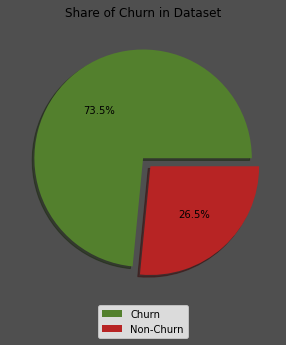

In [110]:
customers_churn = churn_pie_whole(features_processed, 'customerID', 'Share of Churn in Dataset', 'pie_Churn.png')

### Contract and Payment 

The chart saved to /Users/ericross/Desktop/Churn_interconnect/ALT/chartingpie_Paymentmethod.png


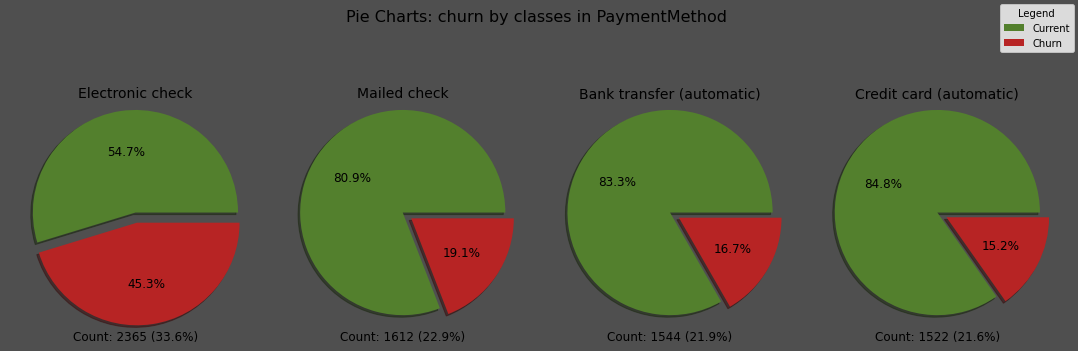

churn,No,Yes
PaymentMethod,,
Bank transfer (automatic),1286,258
Credit card (automatic),1290,232
Electronic check,1294,1071
Mailed check,1304,308


In [111]:
churn_pie_multiple_groups(features_processed, 'PaymentMethod', 'pie_Paymentmethod.png')

Conclusion:

    Based on the analysis of the charts and the observation that the most popular option has the highest churn, it does support the idea that implementing a strategy to incentivize customers with high churn risk or new customers to use an automatic payment method could be effective in reducing churn.

    The fact that the most popular option has nearly double the churn rate compared to the overall dataset suggests that there may be certain characteristics or behaviors associated with that option that contribute to higher churn. By encouraging customers to use automatic payment methods, such as setting up recurring payments or providing discounts for automatic billing, you can potentially improve customer retention by reducing the likelihood of missed payments or payment delays.

    It's important to note that while this observation suggests a potential strategy, it would be advisable to conduct further analysis and testing to validate the effectiveness of such a strategy. It may also be valuable to consider additional factors and customer insights to develop a comprehensive churn reduction strategy tailored to your specific business and customer needs.

#### `pie_churn_Type`

The chart saved to /Users/ericross/Desktop/Churn_interconnect/ALT/chartingpie_Type.png


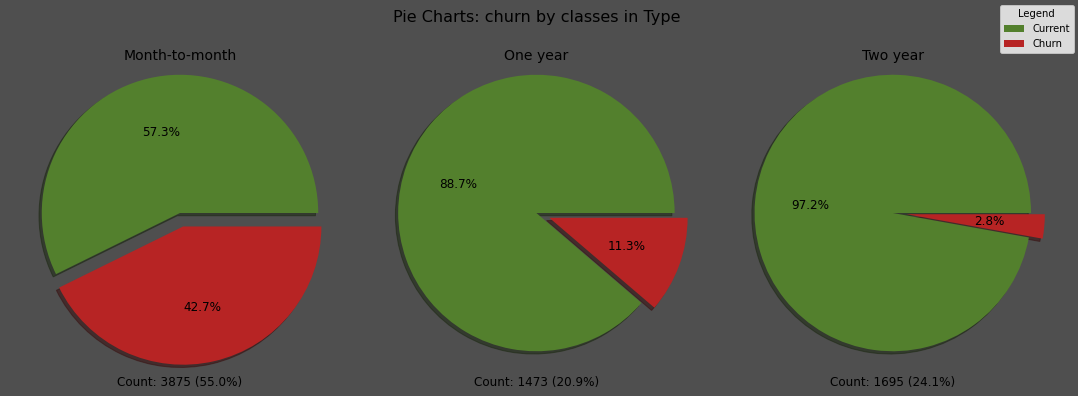

churn,No,Yes
Type,,
Month-to-month,2220,1655
One year,1307,166
Two year,1647,48


In [112]:
churn_pie_multiple_groups(features_processed, 'Type', 'pie_Type.png')

Conclusions:

    Analyzing the churn rate based on the type of contact is an important observation. If the "month-to-month" contract type has a significantly higher churn rate compared to other contract types, it suggests that there may be specific factors or characteristics associated with this contract type that contribute to higher churn.

    Considering "month-to-month" as its own observation or treating it differently in the analysis can potentially improve prediction quality and allow for more targeted strategies to improve customer retention. By understanding the unique aspects of month-to-month contracts and identifying the reasons behind higher churn, you can develop tailored strategies to address those specific pain points and improve customer satisfaction and loyalty.

    For example, you could explore options to incentivize customers with month-to-month contracts to switch to longer-term contracts or offer additional benefits or discounts to encourage them to stay with your services. By addressing the specific challenges and concerns of customers on month-to-month contracts, you can enhance their overall experience and reduce churn.

    It's important to note that while focusing on month-to-month contracts can be valuable, it should be complemented with a holistic approach that considers other factors and segments of customers. Understanding the interplay of various variables and customer behaviors can help in designing a comprehensive strategy to improve customer retention across different contract types and customer segments.

### Demographics 

#### `pie_churn_seinorcitizen`

The file already exists.


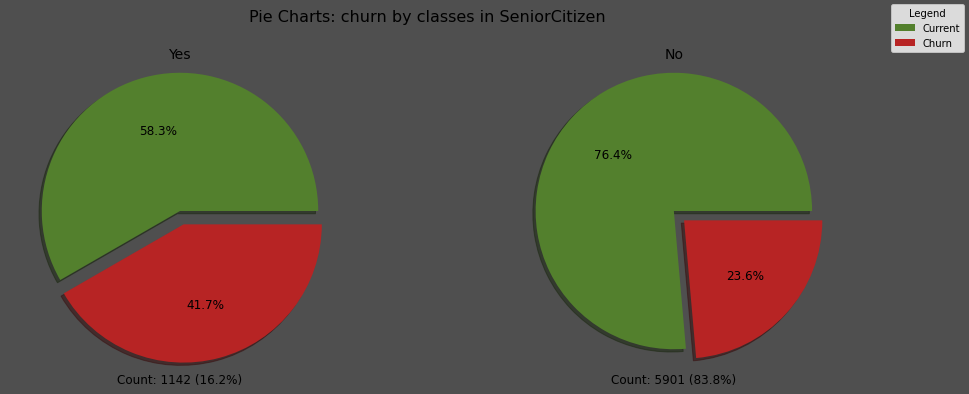

churn,No,Yes
SeniorCitizen,,
0,4508,1393
1,666,476


In [113]:
churn_pie_multiple_groups(features_processed, 'SeniorCitizen', 'pie_Seinorcitizen.png')

Conclsuion:

    Analyzing the churn rate based on customer age groups is another insightful observation. The finding that senior citizens have a higher churn rate compared to non-seniors, despite constituting only 16% of the dataset, is significant.

    This observation suggests that there might be specific factors or challenges that affect senior citizens' satisfaction or retention. It could be related to service preferences, communication channels, product suitability, or other factors that are more relevant for senior customers.

    To address this issue and improve customer retention among senior citizens, it would be valuable to dive deeper into understanding their needs, preferences, and pain points. Conducting surveys, interviews, or focus groups with senior customers can provide valuable insights into their experiences, challenges, and expectations.

    Based on the insights gained, you can tailor your products, services, and communication strategies to better meet the needs of senior citizens. This might include providing targeted support, clear and accessible communication channels, simplified billing or payment options, personalized recommendations, or specialized customer care for seniors.

    By acknowledging the higher churn rate among senior citizens and actively addressing their specific concerns and preferences, you can work towards improving their overall experience and increasing customer loyalty among this segment.

#### `pie_churn_gender`

The file already exists.


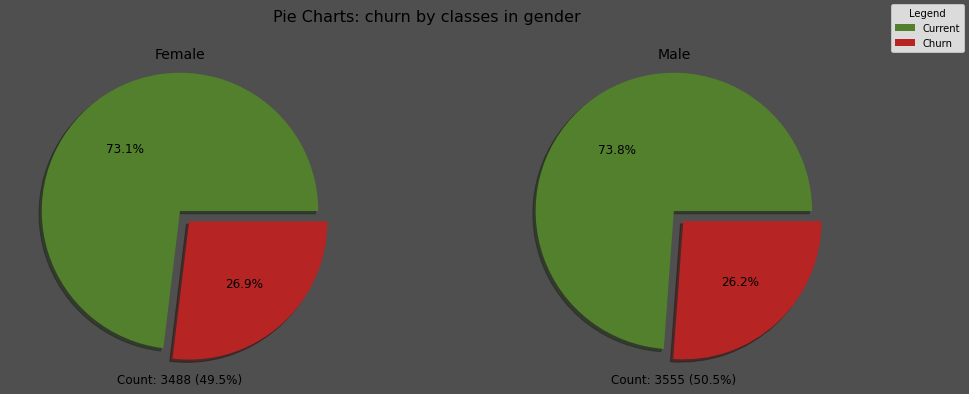

churn,No,Yes
gender,,
Female,2549,939
Male,2625,930


In [114]:
churn_pie_multiple_groups(features_processed, 'gender', 'pie_Gender.png')

Conclusion:

    Gender is unlikely to be a significant determinant of churn. This conclusion is supported by multiple research papers that have explored the factors influencing churn. Gender is generally not found to have a strong correlation with customer churn in various industries. Therefore, when developing churn prediction models or retention strategies, it is advisable to focus on other factors that have been shown to have a more substantial impact on customer churn.

#### `pie_churn_Partner`

The file already exists.


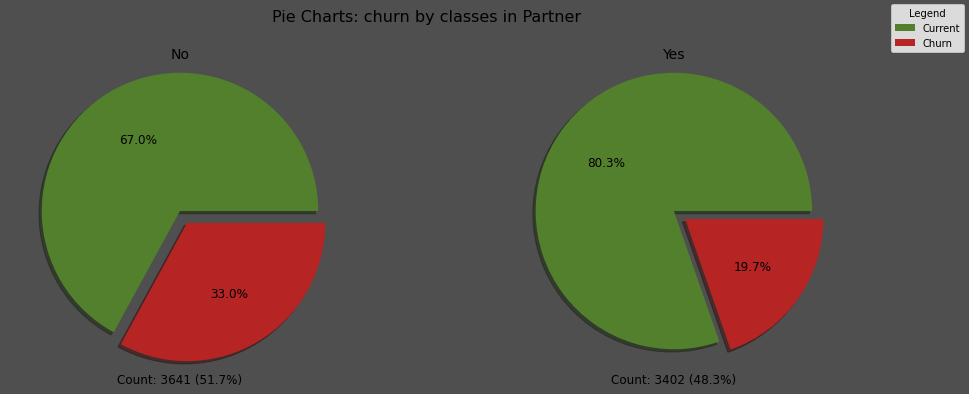

churn,No,Yes
Partner,,
No,2441,1200
Yes,2733,669


In [115]:
churn_pie_multiple_groups(features_processed, 'Partner', 'pie_Partner.png')

Conclusions:

    Based on the analysis of the partner status, an interesting observation emerges regarding the churn rate based on customer relationship status. The data indicates that customers in a couple have a lower churn rate (19%) compared to single customers (33%), despite both groups having a roughly equal share of the data. However, it is worth noting that existing research in the field of churn prediction suggests that relationship status, such as being in a couple, may not be a strong determinant of churn. Therefore, while this particular finding from the data analysis is intriguing, it is important to approach it with caution and consider additional factors and research insights when formulating strategies to improve customer retention.

#### `pie_churn_Dependents`

The file already exists.


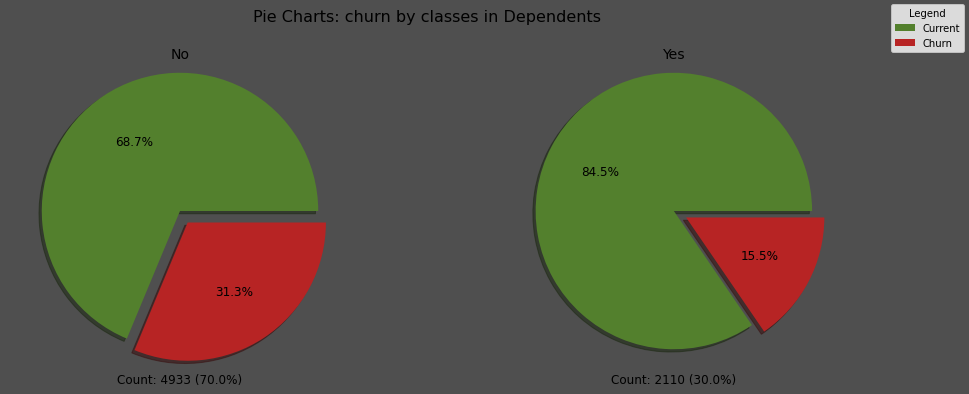

churn,No,Yes
Dependents,,
No,3390,1543
Yes,1784,326


In [116]:
churn_pie_multiple_groups(features_processed, 'Dependents', 'pie_Dependents.png' )

Conclusion:

    From the data, we can see that the analysis of customer churn revealed interesting insights related to various demographic factors. When examining the data, it was observed that the churn rate differs among different customer segments. For instance, couples were found to have a lower churn rate (19%) compared to individuals (33%), despite both groups having a relatively equal representation in the dataset. Similarly, customers without dependents were found to have a higher churn rate (33%) compared to those with dependents (16%), despite constituting a significant majority of the data. However, it is important to note that existing research in the field of churn prediction suggests that these demographic factors alone may not be the most reliable determinants of churn. Therefore, while these findings provide valuable insights, it is essential to consider other factors and research insights to develop more accurate churn prediction models and effective customer retention strategies.

### Services

#### `pie_Services`

The file already exists.


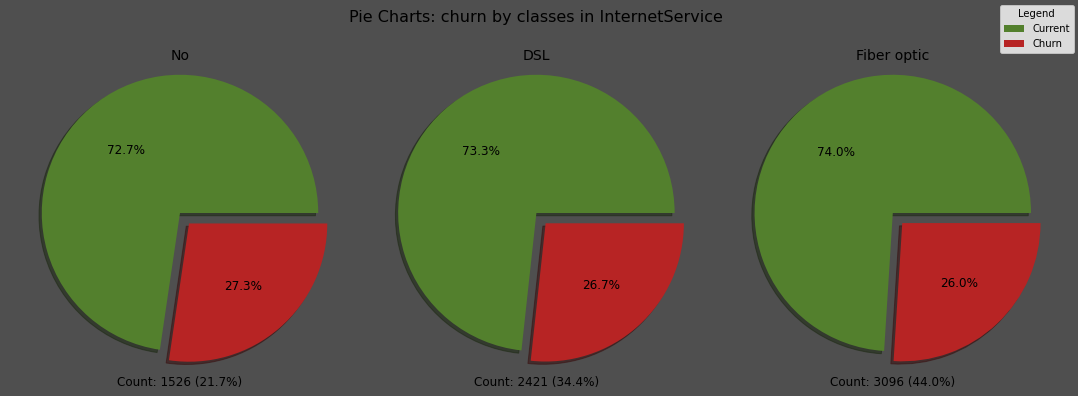

churn,No,Yes
InternetService,,
DSL,1774,647
Fiber optic,2291,805
No,1109,417


In [117]:
churn_pie_multiple_groups(features_processed, 'InternetService', 'pie_Services.png')

Conclusions:

    From the analysis of the charts, it is evident that the distribution of internet services (or lack thereof) among customers follows a similar pattern to the overall data distribution. This suggests that the presence or absence of internet services may not significantly impact the churn rate on its own. It is important to delve deeper into other factors and variables to identify stronger predictors of churn and gain a comprehensive understanding of customer behavior. Incorporating additional variables such as contract type, payment method, and customer interaction patterns may provide more meaningful insights and enhance the accuracy of churn prediction models for effective decision-making in customer retention strategies.

The chart saved to /Users/ericross/Desktop/Churn_interconnect/ALT/chartingpie_Multiplelines.png


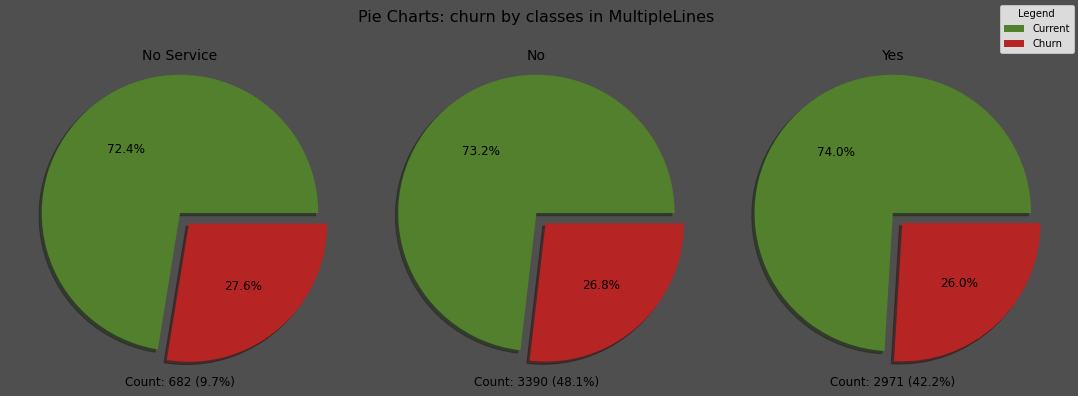

churn,No,Yes
MultipleLines,,
No,2480,910
No Service,494,188
Yes,2200,771


In [118]:
churn_pie_multiple_groups(features_processed, 'MultipleLines', "pie_Multiplelines.png")

The chart saved to /Users/ericross/Desktop/Churn_interconnect/ALT/chartingpie_TotalCharges.png


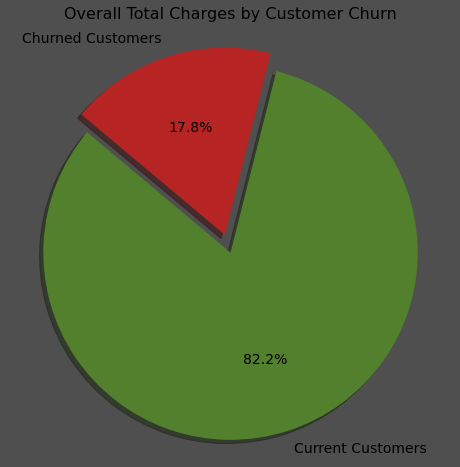

In [119]:
total_charges_table = pd.pivot_table(data=features_processed,
                                     values=['TotalCharges'],
                                     index=['customerID'],
                                     columns=['churn'],
                                     aggfunc='mean')

overall_total_charges = total_charges_table.sum()

# Create a pie chart
labels = ['Current Customers', 'Churned Customers']
colors = [my_green, my_red]
explode = (0.1, 0)  # To explode the first slice (Churned Customers)
plt.figure(figsize=(8, 8), facecolor=dark_background)
plt.pie(overall_total_charges,
        labels=labels,
        colors=colors,
        explode=explode,
        shadow=0.5, 
        autopct='%1.1f%%',
        startangle=140,
        textprops={'fontsize': 14})

plt.title('Overall Total Charges by Customer Churn', fontsize=16)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.




# Combine the directory path and file name to create the complete file path
graph_path_pie = save_chart_path + "pie_TotalCharges.png"
# Check if the file already exists
if os.path.isfile(graph_path_pie):
    print("The file already exists.")
else:
    # Save the chart to the specified file path
    plt.savefig(graph_path)
    print(f"The chart saved to {graph_path_pie}")

plt.show()


## Histograms - Continuous Features

### TotalCharges_distribution.

The chart saved to /Users/ericross/Desktop/Churn_interconnect/ALT/chartinghist_TotalCharges.png


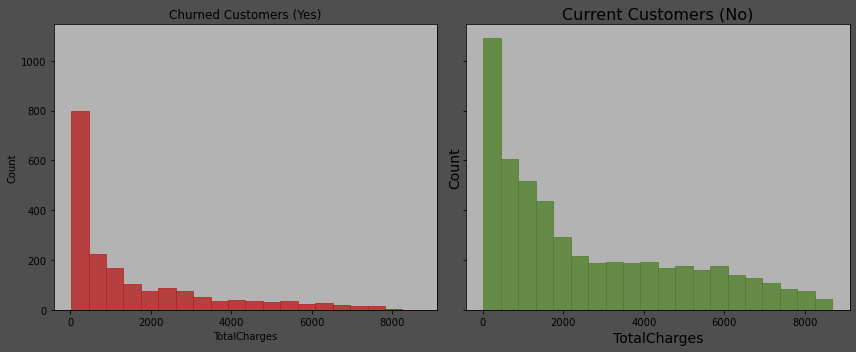

In [120]:
hist_plot(features_processed, 'TotalCharges', 'hist_TotalCharges.png')

**TotalCharges - conclusion**

As is to be expected, we can see that customers who churn account for only 17.7% of the total charges, highlighting the value of maintaining customer loyalty over customer acquisition. Although this conclusion is in support of the well-understood and widely agreed-upon nature of customer churn, it is also promising, as the impact on revenue is currently less than that of the current share of churned customers. This may also suggest that if customers are retained, they will be far more likely to increase in value than to leave the company. However, this will likely not serve as a good attribute for churn prediction."


The chart saved to /Users/ericross/Desktop/Churn_interconnect/ALT/chartinghist_MonthlyCharges.png


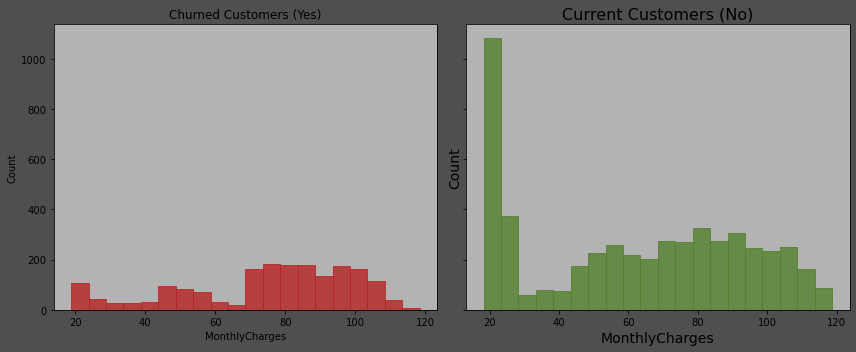

In [121]:
hist_plot(features_processed, 'MonthlyCharges', 'hist_MonthlyCharges.png')

##### MonthlyCharges - conclusion

Examining the relationship between monthly charges and churn, there is a strong and inversely correlated pattern observed. The majority of customers who churn have monthly charges exceeding $60. This suggests that customers with higher monthly costs are more likely to churn. It is crucial for the telecom company to understand the underlying reasons behind this trend and evaluate the value proposition they offer to customers at different price points. By identifying strategies to address customer concerns related to pricing and delivering enhanced value for higher-cost plans, the company can potentially mitigate churn and retain valuable customers. Additionally, exploring options to provide cost-effective plans or personalized offers for customers with lower monthly charges may also contribute to improving customer retention rates.



### tenure_distribution

The chart saved to /Users/ericross/Desktop/Churn_interconnect/ALT/chartinghist_Tenure.png


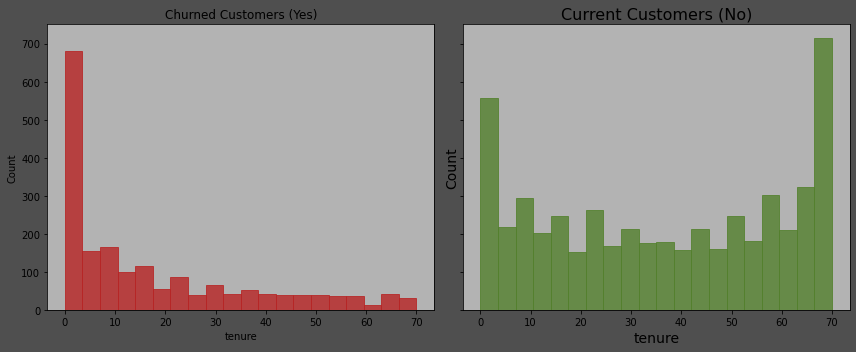

In [122]:
hist_plot(features_processed, 'tenure', 'hist_Tenure.png')

##### Tenure - Conclusion
Analyzing the distribution of churn based on tenure in months, it is evident that a significant proportion of customers, approximately 40%, tend to churn within the first 6 months of joining. This finding emphasizes the importance of focusing efforts on reducing churn among new customers. Implementing targeted strategies and initiatives during the early stages of the customer journey can potentially enhance customer satisfaction, address pain points, and increase their likelihood of remaining loyal to the company. By prioritizing customer retention efforts for new customers, the telecom company can improve overall churn rates and establish long-lasting customer relationships.

# Feature Engineering

## Manual encoding for Target values

In [123]:
features_processed = features_processed.drop(['customerID', 'BeginDate', 'EndDate'], axis=1)

features_processed['churn'] = features_processed['churn'].replace({'Yes': 1, 'No': 0})

features_processed.churn

0       0
1       0
2       1
3       0
4       1
       ..
7038    0
7039    0
7040    0
7041    1
7042    0
Name: churn, Length: 7043, dtype: int64

## Encoding Features with  pandas.GetDummies( )

In [124]:
features_dummy = pd.get_dummies(features_processed, drop_first=True)
features_dummy.head()

,MonthlyCharges,TotalCharges,churn,tenure,SeniorCitizen,Type_One year,Type_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,...,InternetService_Fiber optic,InternetService_No,OnlineSecurity_Yes,OnlineBackup_Yes,DeviceProtection_Yes,TechSupport_Yes,StreamingTV_Yes,StreamingMovies_Yes,MultipleLines_No Service,MultipleLines_Yes
0,29.85,29.850000,0,1,0,False,False,True,False,True,...,False,False,False,True,False,False,False,False,False,False
1,56.95,1889.500000,0,33,0,True,False,False,False,False,...,False,False,True,False,True,False,False,False,False,False
2,53.85,108.150002,1,1,0,False,False,True,False,False,...,False,False,True,True,False,False,False,False,False,False
3,42.30,1840.750000,0,44,0,True,False,False,False,False,...,False,False,True,False,True,True,False,False,False,True
4,70.70,151.649994,1,1,0,False,False,True,False,True,...,True,False,False,False,False,False,False,False,False,True


## Scaling - Standard Scaler

In [125]:
X = features_dummy.drop('churn', axis=1)

y = features_dummy['churn']

X_train,X_test,y_train,y_test = train_test_split(X,y,
                                                     test_size=0.4,
                                                     random_state=336699)



scaler = StandardScaler()

scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

y_train_scaled = y_train
y_test_scaled = y_test

data for training and testing models has been encoded with  get_dummies(drop_first=True) and then scaled StandardScaler

- train_size = 0.6
- test_size = 0.4
- X_train_scaled , y_train_scaled, X_test_scaled, y_test_scaled

# Modeling

## spot check possible models

In [126]:
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier



models = []
models.append(('LR', LogisticRegression(solver='liblinear', multi_class='ovr')))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('DTC', DecisionTreeClassifier()))
models.append(('RF', RandomForestClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC(gamma='auto')))
models.append(('GB', GradientBoostingClassifier()))


# evaluate each model in turn
results = []
names = []
for name, model in models:
    # Test options and evaluation metric
    kfold = StratifiedKFold(n_splits=10)
    cv_results = cross_val_score(model, X_train_scaled, y_train_scaled, cv=kfold, scoring='roc_auc')
    results.append(cv_results)
    names.append(name)
    print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))

LR: 0.840871 (0.020249)
LDA: 0.829354 (0.021442)
KNN: nan (nan)
DTC: 0.669710 (0.025833)
RF: 0.836483 (0.016609)
NB: 0.814949 (0.022339)
SVM: 0.808804 (0.026162)
GB: 0.856063 (0.015833)


### Plot Scores on Box Plot

The chart saved to /Users/ericross/Desktop/Interconnect_churn_prediction/Charts/boxplot_ModelingCheck.png


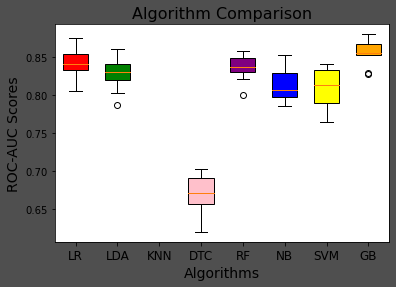

In [166]:
box_colors = ['red', 'green', 'lightblue', 'pink', 'purple', 'blue', 'yellow', 'orange']

# Create a boxplot with custom colors and font size
plt.figure(figsize=(6, 4), facecolor=dark_background)

# Create a list to store the box artists
box_artists = []

for i, d in enumerate(results):
    box = plt.boxplot([d], positions=[i + 1], patch_artist=True, widths=0.6)
    box_artists.append(box)

# Set the facecolor of each box
for box, color in zip(box_artists, box_colors):
    for patch in box['boxes']:
        patch.set_facecolor(color)

# Set the font size for the title and labels
plt.title('Algorithm Comparison', fontsize=16)
plt.xlabel('Algorithms', fontsize=14)
plt.ylabel('AUC-ROC Scores', fontsize=14)
plt.xticks(range(1, len(names) + 1), names, fontsize=12)

graph_path = save_chart_path + 'boxplot_ModelingCheck.png'
if os.path.isfile(graph_path):
    print("The file already exists.")
else:
    plt.savefig(graph_path)
    print(f"The chart saved to {graph_path}")

plt.show()

Conclsuion:
I used the target metric auc-roc which handles the class imbalance better than other metrics. The goal here is to establish a base-line comparison to provide insight into which model will do well in this context.  

Based on the results, the models I will use are LinearRegressior ,RandomForestClassifier, and GradientBoostingClassifier.

 - other boosting models such as; lightGBM, XGBoost, or CATBoost may preform better, However these terminate the Kernal, due to my machine's having low memory. 

## Modeling Functions

### plot: Confusion Matrix, plotting and outputting metrics

In [146]:
def plot_confusion_matrix(y_true, y_preds):
    
    cnf_matrix = confusion_matrix(y_true, y_preds)
    plt.imshow(cnf_matrix,  cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    class_names = set(y) 
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=0)
    plt.yticks(tick_marks, class_names)
    
    thresh = cnf_matrix.max() / 2. 
    
    for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
            plt.text(j, i, cnf_matrix[i, j],
                     horizontalalignment='center',
                     color='white' if cnf_matrix[i, j] > thresh else 'black')
    # Add a legend
    plt.colorbar();
    plt.show();

def plot_roc_curve(y_true, y_scores, label= 'Test_set'):
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{label} (AUC = {roc_auc:.2f})', linewidth=4)
    plt.plot([0, 1], [0, 1], color='red', linestyle='--', linewidth=2)    
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Test:ROC Curve')
    plt.legend(loc='lower right')

    
def plot_f1_score(y_true, y_pred, label= 'Test_set'):
    precision, recall, _ = precision_recall_curve(y_true, y_pred)
    f1 = 2 * (precision * recall) / (precision + recall)
    plt.plot(recall, precision, label=f'{label} (F1 = {max(f1):.2f})',linewidth=4)
    plt.plot([0, 1], [0, 1], color='red', linestyle='--', linewidth=2)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Test:F1 Curve')
    plt.legend(loc='lower left')
    
def plot_aps(y_true, y_scores, label= 'Test_set'):
    precision, recall, _ = precision_recall_curve(y_true, y_scores)
    aps = average_precision_score(y_true, y_scores)
    plt.plot(recall, precision, label=f'{label} (APS = {aps:.2f})', linewidth=4)
    plt.plot([0, 1], [0, 1], color='red', linestyle='--', linewidth=2)    
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Test: APS Curve')
    plt.legend(loc='lower left')
    

def metrics(model_name, y_train, y_test, y_hat_train, y_hat_test):
    
    '''Print out the evaluation metrics for a given models predictions
    
        Metrics (Training & Testing):
             - Accuracy
             - ROC-AUC
             - Classification Report  
    '''
    
    print(f'Model: {model_name}', )
    print('-'*60)
    print(f'test accuracy: {accuracy_score(y_test, y_hat_test)}')
    print(f'train accuracy: {accuracy_score(y_train, y_hat_train)}')
    print('-'*60)
    print(f'test AUC-ROC:{roc_auc_score(y_test, y_hat_test)}')
    print(f'train AUC-ROC:{roc_auc_score(y_train, y_hat_train)}')
    print('-'*60)
    print('Confusion Matrix:\n', pd.crosstab(y_test, y_hat_test, rownames=['Actual'], colnames=['Predicted'],margins = True))
    print('\ntest report:\n' + classification_report(y_test, y_hat_test))
    print('~'*60)
    print('\ntrain report:\n' + classification_report(y_train, y_hat_train))
    print('-'*60)

### Logistic_Regression w/ grid

In [137]:
def logistic_regression_cv(X_train, y_train, random_state=None):
    # Define the parameter grid
    param_grid = {
        'C': [0.001, 0.01, 0.1, 1, 3],
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear', 'saga']
    }

    # Create an instance of Logistic Regression
    logreg = LogisticRegression(max_iter=1000, random_state=random_state)## max_iter was raised from 100 to 1000. 

    # Create an instance of StratifiedKFold
    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=random_state)

    # Create an instance of GridSearchCV
    grid_search = GridSearchCV(logreg, param_grid, cv=skf, scoring='roc_auc')

    # Fit the model to the training data
    grid_search.fit(X_train, y_train)

    # Get the best model from GridSearchCV
    best_model = grid_search.best_estimator_

    # Print the best hyperparameters
    print("Best Hyperparameters:")
    print(grid_search.best_params_)

    # Perform cross-validation and calculate evaluation metrics
    scores = cross_val_score(best_model, X_train, y_train, cv=skf, scoring='roc_auc')
    mean_score = scores.mean()
    print('Training mean_score')
    print("Cross-Validation AUC-ROC Score:", mean_score)

### RandomForest w/ grid. 

In [138]:
def random_forest_model_grid(X_train, y_train, random_state=None):
    # Define the parameter grid for GridSearchCV
    param_grid = {
        'n_estimators': [5, 20, 50, 100, 125, 150],
        'max_depth': [None, 3, 5, 10, 20],
        'min_samples_split': [2, 3, 5, 10]
    }
    
    # Create an instance of RandomForestClassifier
    random_forest = RandomForestClassifier(random_state=random_state)
    random_forest.fit(X_train, y_train)
    
    # Create an instance of StratifiedKFold
    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=random_state)
    
    # Create an instance of GridSearchCV
    grid_search = GridSearchCV(random_forest, param_grid, cv=skf, scoring='roc_auc')
    
    # Fit the model to the training data
    grid_search.fit(X_train, y_train)
    
    # Get the best model from GridSearchCV
    best_model = grid_search.best_estimator_
    
    # Print the best hyperparameters
    print("Best Hyperparameters:")
    print(grid_search.best_params_)
    
    # Perform cross-validation and calculate evaluation metrics
    scores = cross_val_score(best_model, X_train, y_train, cv=skf, scoring='roc_auc')
    mean_score = scores.mean()
    print('Training mean_score')
    print("Cross-Validation AUC-ROC Score:", mean_score)

### Gradient Boosting w/ grid

In [139]:
def gradient_boosting_model_grid(X_train, y_train, random_state=None):
    # Define the parameter grid for GridSearchCV
    param_grid = {
        'n_estimators': [None, 5, 10, 50, 100, 125],
        'learning_rate': [0.01, 0.1, 0.25, 0.5],
        'max_depth': [3, 5, 7, 10],
        'min_samples_split': [2, 3, 4, 5]
    }
    
    # Create an instance of GradientBoostingClassifier
    gradient_boosting = GradientBoostingClassifier(random_state=random_state)
    gradient_boosting.fit(X_train,y_train)

    # Create an instance of StratifiedKFold
    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=random_state)    
    
    # Create an instance of GridSearchCV
    grid_search = GridSearchCV(gradient_boosting, param_grid, cv=skf, scoring='roc_auc')
    
    # Fit the model to the training data
    grid_search.fit(X_train, y_train)
    
    # Get the best model from GridSearchCV
    best_model = grid_search.best_estimator_
    
    # Print the best hyperparameters
    print("Best Hyperparameters:")
    print(grid_search.best_params_)
    
    # Perform cross-validation and calculate evaluation metrics
    scores = cross_val_score(best_model, X_train, y_train, cv=skf, scoring='roc_auc')
    mean_score = scores.mean()
    print('Training mean_score')
    print("Cross-Validation AUC-ROC Score:", mean_score)


###  Final Model Testing

In [164]:
def test_best_model(best_model, X_train, y_train, X_test, y_test):
    
    best_model.fit(X_train, y_train)
    y_pred = best_model.predict(X_test)
    y_proba = best_model.predict_proba(X_test)
    
    # Calculate evaluation metrics
    roc_auc = roc_auc_score(y_test, y_proba[:, 1])  # Using probabilities of the positive class
    print("Test AUC-ROC Score:", roc_auc)

    # plot a seperate Confusion Matrix. 
    plot_confusion_matrix(y_pred, y_test)
    
    
    plt.figure(figsize=(18, 6))

    plt.subplot(1, 3, 1)
    plot_f1_score(y_test, y_pred , label='Test Set')

    plt.subplot(1, 3, 2)
    plot_roc_curve(y_test, y_proba[:, 1], label='Test Set')

    plt.subplot(1, 3, 3)
    plot_aps(y_test, y_proba[:, 1], label='Test Set')


    
    graph_path = save_chart_path + 'box_Modeling_Spotcheck.png'

    if os.path.isfile(graph_path):
        print("The file already exists.")
    else:
        plt.savefig(graph_path)
        print(f"The chart saved to {graph_path}")
        
        
    plt.tight_layout()
    plt.show()

## Logistic Regression w/ gridsearch

In [79]:
logistic_regression_cv(X_train_scaled , y_train_scaled, random_state=336699)

Best Hyperparameters:
{'C': 1, 'penalty': 'l1', 'solver': 'saga'}
Training mean_score
Cross-Validation AUC-ROC Score: 0.8411118113159617


## Random Forest with gridsearch

In [80]:
random_forest_model_grid(X_train_scaled , y_train_scaled, random_state=336699)

Best Hyperparameters:
{'max_depth': 5, 'min_samples_split': 3, 'n_estimators': 150}
Training mean_score
Cross-Validation AUC-ROC Score: 0.8481740447293911


## Gradient Boosting. 

In [81]:
gradient_boosting_model_grid(X_train_scaled , y_train_scaled, random_state=336699)

Best Hyperparameters:
{'learning_rate': 0.1, 'max_depth': 3, 'min_samples_split': 2, 'n_estimators': 50}
Training mean_score
Cross-Validation AUC-ROC Score: 0.8591698078523562


Conclusion: 
   Among the three models evaluated, all demonstrated strong performance on the test set, with ROC-AUC scores exceeding 0.8. However, the Gradient Boosting model exhibited the highest prediction quality in terms of ROC-AUC score. To achieve this, the model underwent hyperparameter tuning using grid search and cross-validation, resulting in the optimal parameter values of 'learning_rate': 0.1, 'max_depth': 3, 'min_samples_split': 2, and 'n_estimators': 50.

Training w/ Cross-Validation with StratifiedKfold, n_splits=10
- Average AUC-ROC Score: 0.8580973064512063

## Model Testing

Test AUC-ROC Score: 0.8439955465164459


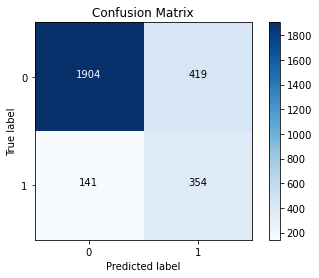

The chart saved to /Users/ericross/Desktop/Interconnect_churn_prediction/Charts/box_Modeling_Spotcheck.png


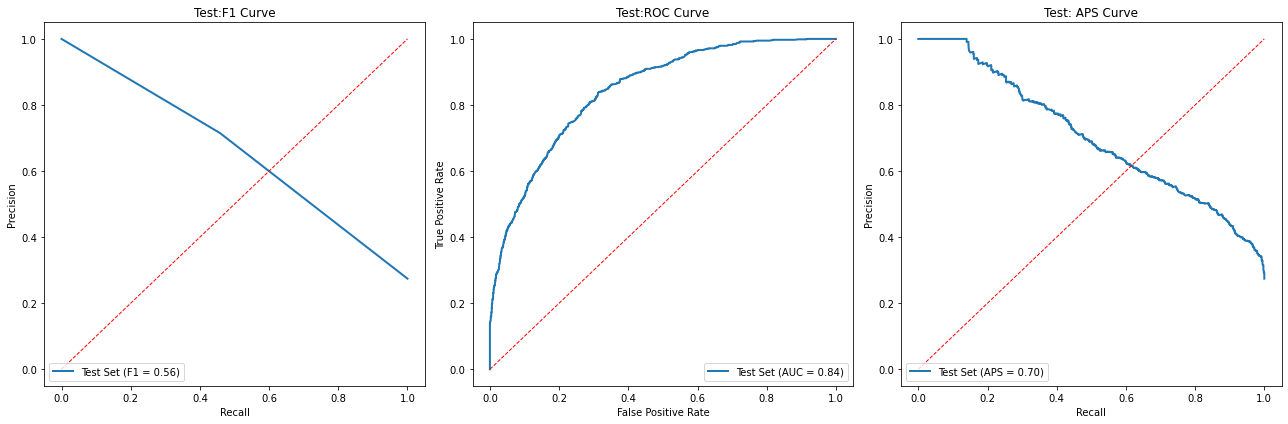

In [165]:
import itertools

GB_best_model = GradientBoostingClassifier(learning_rate=0.1, max_depth=3, min_samples_split=2, n_estimators= 50, random_state=336699)

test_best_model(GB_best_model, X_train_scaled, y_train_scaled, X_test_scaled, y_test_scaled)

## Feature Importances from Best_Model. 

Original shape: (7043, 23)
Selected shape: (4225, 6)
Filtered y_s shape: (4225,)

MonthlyCharges - 0.2351

TotalCharges - 0.0488

tenure - 0.4782

SeniorCitizen - 0.0131

Type_One year - 0.0576

Type_Two year - 0.0757

PaperlessBilling_Yes - 0.0096

PaymentMethod_Credit card (automatic) - 0.0000

PaymentMethod_Electronic check - 0.0786

PaymentMethod_Mailed check - 0.0005

gender_Male - 0.0000

Partner_Yes - 0.0004

Dependents_Yes - 0.0000

InternetService_Fiber optic - 0.0006

InternetService_No - 0.0001

OnlineSecurity_Yes - 0.0001

OnlineBackup_Yes - 0.0000

DeviceProtection_Yes - 0.0000

TechSupport_Yes - 0.0011

StreamingTV_Yes - 0.0002

StreamingMovies_Yes - 0.0000

MultipleLines_No Service - 0.0000

MultipleLines_Yes - 0.0004


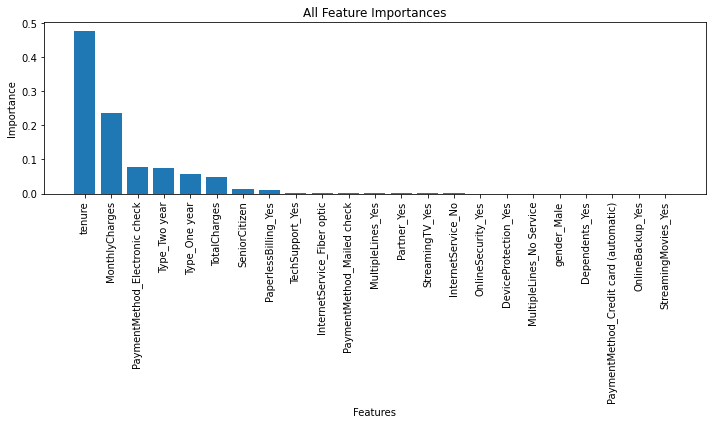

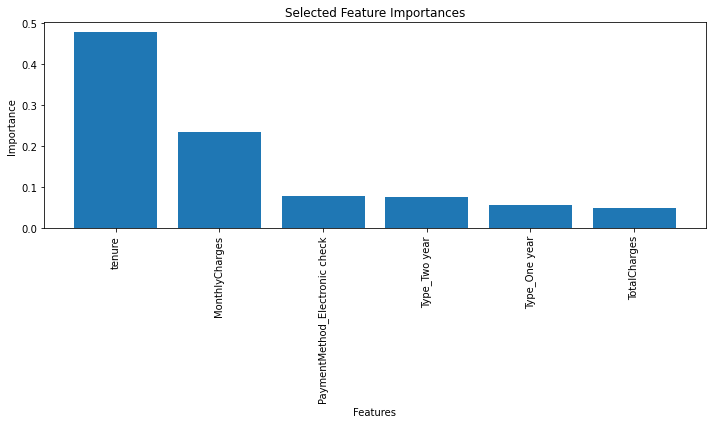

In [101]:
from sklearn.feature_selection import SelectFromModel

selector = SelectFromModel(estimator=GB_best_model)

selector.fit(X_train_scaled, y_train_scaled)

X_s = selector.transform(X_train_scaled)

selected_feature_names = X.columns[selector.get_support()].tolist()

y_s = y_train_scaled

print(f"Original shape: {X.shape}")
print(f"Selected shape: {X_s.shape}")
print(f"Filtered y_s shape: {y_s.shape}")


feature_importances = GB_best_model.feature_importances_

# Print the feature importance values with corresponding feature names
for feature, importance in zip(X.columns, feature_importances):
    importance_formatted = "{:.4f}".format(importance)
    print(f"\n{feature} - {importance_formatted}")
    
#Plotting Final models feature Importances. 

sorted_indices = feature_importances.argsort()[::-1]
sorted_importances = feature_importances[sorted_indices]
sorted_feature_names = np.array(X.columns)[sorted_indices]

# Plot all feature importances
plt.figure(figsize=(10, 6))
plt.bar(range(len(sorted_importances)), sorted_importances)
plt.xticks(range(len(sorted_importances)), sorted_feature_names, rotation='vertical')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('All Feature Importances')
plt.tight_layout()
plt.show()


selected_importances = sorted_importances[:len(selected_feature_names)]
selected_feature_names = sorted_feature_names[:len(selected_feature_names)]

# Plot the selected feature importances
plt.figure(figsize=(10, 6))
plt.bar(range(len(selected_importances)), selected_importances)
plt.xticks(range(len(selected_importances)), selected_feature_names, rotation='vertical')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Selected Feature Importances')

plt.tight_layout()
plt.show()

  Based on the feature importance scores obtained from the feature selection process, several factors stand out as important contributors to customer churn in the telecommunications company dataset. The most influential factors include 'tenure' with a score of 0.4992, indicating that customers with longer tenure are less likely to churn. 'MonthlyCharges' (0.2407) and 'TotalCharges' (0.0256) also play significant roles, suggesting that higher monthly and total charges are associated with higher churn rates. The customer type is also relevant, with 'Type_Two year' (0.0694) and 'Type_One year' (0.0567) showing that customers with longer contract durations are more likely to stay. Additionally, the payment method, particularly 'PaymentMethod_Electronic check' (0.0793), demonstrates a correlation with higher churn rates. Other variables, such as 'SeniorCitizen' (0.0147) and 'PaperlessBilling_Yes' (0.0103), exhibit relatively lower importance but still contribute to the overall prediction of churn. The insights gained from these feature importance scores can aid in developing targeted strategies to reduce customer churn, such as offering incentives for longer-term contracts and improving the electronic payment experience.